In [15]:
import os
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay
)

# Modeling
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils.multiclass import type_of_target
from joblib import dump

In [16]:
# -----------------------------
# 1) CONFIG
# -----------------------------
csv_path   = "/content/RandomForest_dataset.xlsx"     # your file
target_col = "Approved"                     # change if your target differs
model_out  = "rf_model.joblib"

In [17]:
# -----------------------------
# 2) LOAD DATA
# -----------------------------
df = pd.read_excel(csv_path)

print("Shape:", df.shape)
print("\nColumns:", list(df.columns))
print("\nHead:\n", df.head())

if target_col not in df.columns:
    raise ValueError(f"Target column '{target_col}' not found. Please set target_col correctly.")


Shape: (20, 7)

Columns: ['Income', 'CreditScore', 'Age', 'EmploymentYears', 'DebtToIncome', 'HasDefault', 'Approved']

Head:
    Income  CreditScore  Age  EmploymentYears  DebtToIncome  HasDefault  \
0   32000          580   24                1          0.45           0   
1   45000          610   27                2          0.38           0   
2   52000          640   29                3          0.33           0   
3   61000          680   31                4          0.30           0   
4   72000          720   35                6          0.28           0   

   Approved  
0         0  
1         0  
2         1  
3         1  
4         1  


In [18]:
# -----------------------------
# 3) BASIC CLEANING
# -----------------------------
# Drop fully duplicate rows (optional)
df = df.drop_duplicates().reset_index(drop=True)

# Split features/target
y = df[target_col]
X = df.drop(columns=[target_col])

# Detect problem type
t_type = type_of_target(y)
print("\nDetected target type:", t_type)
if t_type not in ["binary", "multiclass"]:
    raise ValueError("This script is for classification (binary/multiclass). Target must be categorical (0/1, etc.).")

# Identify numeric vs categorical columns
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

print("\nNumeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols if categorical_cols else "(none)")


Detected target type: binary

Numeric columns: ['Income', 'CreditScore', 'Age', 'EmploymentYears', 'DebtToIncome', 'HasDefault']
Categorical columns: (none)


In [19]:
# -----------------------------
# 4) PREPROCESSORS
# -----------------------------
numeric_preprocessor = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    # RF doesn't require scaling, but if ranges vary a lot, scaling is ok:
    # ("scaler", StandardScaler())
])

categorical_preprocessor = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocessor, numeric_cols),
        ("cat", categorical_preprocessor, categorical_cols)
    ],
    remainder="drop"
)


In [20]:
# -----------------------------
# 5) SPLIT
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)



In [21]:
# -----------------------------
# 6) PIPELINE: PREPROCESS + RF
# -----------------------------
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=2,
    max_features="sqrt",
    class_weight=None,     # set to "balanced" if your dataset is imbalanced
    random_state=42,
    n_jobs=-1,
    oob_score=False        # OOB needs bootstrap=True and no CV; we do test split + optional CV
)

model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("rf", rf)
])


=== Classification Report (Test) ===
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         2
           1      1.000     1.000     1.000         3

    accuracy                          1.000         5
   macro avg      1.000     1.000     1.000         5
weighted avg      1.000     1.000     1.000         5

Accuracy:  1.000
Precision: 1.000
Recall:    1.000
F1-score:  1.000

Confusion Matrix:
 [[2 0]
 [0 3]]


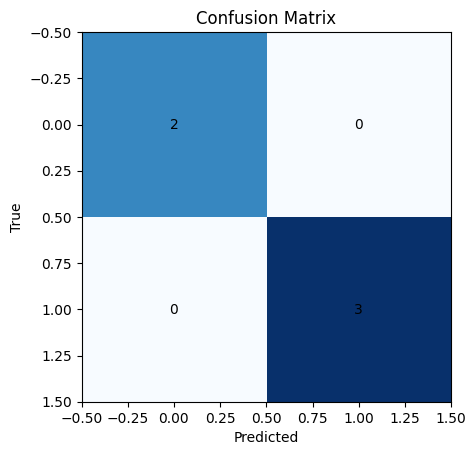


ROC-AUC: 1.000


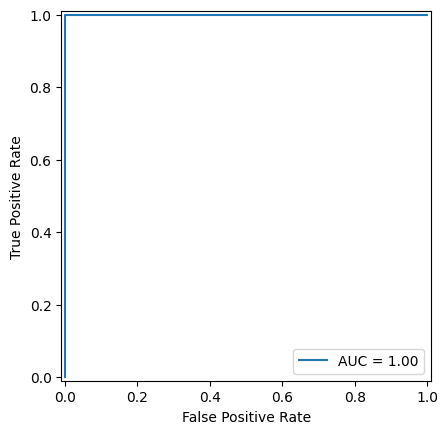

In [22]:

# -----------------------------
# 7) TRAIN
# -----------------------------
model.fit(X_train, y_train)

# -----------------------------
# 8) EVALUATE
# -----------------------------
pred = model.predict(X_test)
print("\n=== Classification Report (Test) ===")
print(classification_report(y_test, pred, digits=3))

acc = accuracy_score(y_test, pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, pred, average="binary" if t_type=="binary" else "weighted")

print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1-score:  {f1:.3f}")

# Confusion matrix
cm = confusion_matrix(y_test, pred)
print("\nConfusion Matrix:\n", cm)

fig, ax = plt.subplots()
im = ax.imshow(cm, cmap="Blues")
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha="center", va="center")
plt.show()

# ROC curve (binary only)
if t_type == "binary":
    # get positive class probability (after pipeline)
    if hasattr(model.named_steps["rf"], "predict_proba"):
        proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, proba)
        roc_auc = auc(fpr, tpr)
        print(f"\nROC-AUC: {roc_auc:.3f}")

        RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
        plt.show()


=== Top Feature Importances ===
DebtToIncome       0.243724
CreditScore        0.234589
Income             0.215167
EmploymentYears    0.152783
Age                0.151236
HasDefault         0.002500
dtype: float64


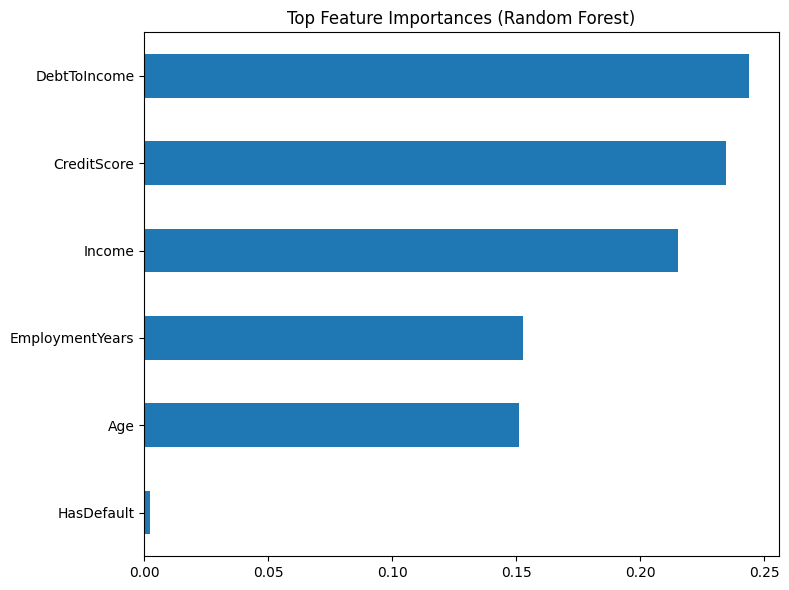

In [23]:
# -----------------------------
# 9) FEATURE IMPORTANCE
# -----------------------------
# Get feature names after preprocessing to map importances
def get_feature_names(preprocessor, numeric_cols, categorical_cols):
    names = []
    # numeric
    names.extend(numeric_cols)
    # categorical (after one-hot)
    if categorical_cols:
        ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
        cat_names = ohe.get_feature_names_out(categorical_cols).tolist()
        names.extend(cat_names)
    return names

# Extract trained RF and feature importances
rf_model = model.named_steps["rf"]
feat_names = get_feature_names(model.named_steps["preprocess"], numeric_cols, categorical_cols)
importances = rf_model.feature_importances_

# Combine & sort
fi = pd.Series(importances, index=feat_names).sort_values(ascending=False)
print("\n=== Top Feature Importances ===")
print(fi.head(20))

# Plot
fi.head(20).plot(kind="barh", figsize=(8,6))
plt.gca().invert_yaxis()
plt.title("Top Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()


In [24]:
# -----------------------------
# 10) OPTIONAL: CROSS-VALIDATION SCORE
# -----------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=cv, scoring="accuracy", n_jobs=-1)
print("\nCV Accuracy (5-fold): mean = %.3f, std = %.3f, scores = %s" % (cv_scores.mean(), cv_scores.std(), np.round(cv_scores, 3)))


CV Accuracy (5-fold): mean = 0.950, std = 0.100, scores = [0.75 1.   1.   1.   1.  ]


In [25]:
# -----------------------------
# 11) SAVE MODEL
# -----------------------------
dump(model, model_out)
print(f"\nSaved trained model to: {model_out}")



Saved trained model to: rf_model.joblib


In [26]:
!pip jupyter nbconvert --to html""

ERROR: unknown command "jupyter"
